[<img src="ml_impossible.png">](https://towardsdatascience.com/ml-impossible-train-a-1-billion-sample-model-in-20-minutes-with-vaex-and-scikit-learn-on-your-9e2968e6f385)

# `vaex` @ MLOps community

## Modern data science with `vaex`: a new approach to DataFrames and pipelines

### New York Taxi Dataset (2009-2015): Exploratory Data Analysis and Machine Learning example (Part II)

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [1]:
import vaex
vaex.multithreading.thread_count_default = 8

import pylab as plt
import numpy as np

import warnings; warnings.simplefilter('ignore')

### ~Load~ Point to the data on disk

In [2]:
# Check file size on disk
!du -h /data/yellow_taxi_*

# Read the same file as before
# df = vaex.open('/data/taxi/yellow_taxi_2012.hdf5')
df = vaex.open('/data/yellow_taxi_2009_2015_f32.hdf5')

108G	/data/yellow_taxi_2009_2015_f32.hdf5
28G	/data/yellow_taxi_2009_2015_f32.parquet
164G	/data/yellow_taxi_2009_2015.hdf5
12G	/data/yellow_taxi_2015_f32.arrow
12G	/data/yellow_taxi_2015_f32.hdf5


### Train test split (by date)

In [3]:
# df_train, df_test = df.ml.train_test_split(test_size=0.15)
df_train = df[:1_026_944_937]
df_test = df[1_026_944_937:]

print(f'Number of samples in the full dataset: {len(df):,}')
print(f'Number of samples in the training set: {len(df_train):,}')
print(f'Number of samples in the test set:      {len(df_test):,}')

# Check if the lengths of the datasets match
assert len(df) == len(df_test) + len(df_train)

Number of samples in the full dataset: 1,173,057,927
Number of samples in the training set: 1,026,944,937
Number of samples in the test set:      146,112,990


### Define the label

In [4]:
# Time in transit (minutes) - This is the target variable
df_train['trip_duration_min'] = (df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                   np.timedelta64(1, 'm')

### Feature engineering

In [5]:
# Speed (miles per hour) - Used for cleaning of the training data
df_train['trip_speed_mph'] = df_train.trip_distance / \
                                ((df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                np.timedelta64(1, 'h'))

In [6]:
# Pickup datetime features
df_train['pickup_time'] = df_train.pickup_datetime.dt.hour + df_train.pickup_datetime.dt.minute / 60.
df_train['pickup_day'] = df_train.pickup_datetime.dt.dayofweek
df_train['pickup_is_weekend'] = (df_train.pickup_day>=5).astype('int')

In [7]:
# Arc distance  in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Create the feature
df_train['arc_distance'] = arc_distance(df_train.pickup_longitude, 
                                        df_train.pickup_latitude, 
                                        df_train.dropoff_longitude, 
                                        df_train.dropoff_latitude).jit_numba()

In [8]:
def direction_angle(theta_1, phi_1, theta_2, phi_2):
    dtheta = theta_2 - theta_1
    dphi = phi_2 - phi_1
    radians = np.arctan2(dtheta, dphi)
    return np.rad2deg(radians)

# Create the feature
df_train['direction_angle'] = direction_angle(df_train.pickup_longitude, 
                                              df_train.pickup_latitude, 
                                              df_train.dropoff_longitude, 
                                              df_train.dropoff_latitude).jit_numba()

### Data cleaning

In [9]:
# Filter abnormal number of passengers
df_train = df_train[(df_train.passenger_count>0) & (df_train.passenger_count<7)]

# Select taxi trips have travelled maximum 7 miles (but also with non-zero distance).
df_train = df_train[(df_train.trip_distance > 0) & (df_train.trip_distance < 7)]

# Filter taxi trips that have durations longer than 25 minutes or that lasted less than 3 minutes
df_train = df_train[(df_train.trip_duration_min > 3) & (df_train.trip_duration_min < 25)]

# Filter out errouneous average trip speeds.
df_train = df_train[(df_train.trip_speed_mph > 1) & (df_train.trip_speed_mph < 60)]

# Define the NYC boundaries
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

# Make a selection based on the boundaries
df_train = df_train[(df_train.pickup_longitude > long_min)  & (df_train.pickup_longitude < long_max) & \
                    (df_train.pickup_latitude > lat_min)    & (df_train.pickup_latitude < lat_max) & \
                    (df_train.dropoff_longitude > long_min) & (df_train.dropoff_longitude < long_max) & \
                    (df_train.dropoff_latitude > lat_min)   & (df_train.dropoff_latitude < lat_max)]

# If there are unknown (N/A) pick-up or drop-off locations, choose a representative value. 
df_train['dropoff_latitude'] = df_train.dropoff_latitude.fillna(value=40.76)
df_train['pickup_latitude'] = df_train.pickup_latitude.fillna(value=40.76)

df_train['dropoff_longitude'] = df_train.dropoff_longitude.fillna(value=-73.99)
df_train['pickup_longitude'] = df_train.pickup_longitude.fillna(value=-73.99)

## `vaex-ml`

A `vaex` package for machine learning. 

Implements various data transformers:
 - numerical scalers
 - categorical encoders
 - PCA transformer
 - GroupBy transformer
 - KBinsDiscretizer transformer
 - etc..
 
Wrappers around other popular model libraries
 - xgboost / lightgbm / catboost
 - scikit-learn
 - tensorflow / keras (predictions only)
 
[Proposal for a between scikit-learn and vaex](https://github.com/scikit-learn/scikit-learn/pull/14963).

scikit-learn PR #14963

In [10]:
import vaex.ml

### Transform features: PCA of the pick-up and drop-off locations

In [11]:
# PCA of the pickup and dropoff locations - helps to "straighten out" the coordinates

# pickup transformations
pca_pu = vaex.ml.PCA(features=['pickup_longitude', 'pickup_latitude'], n_components=2)
df_train = pca_pu.fit_transform(df_train)

# dropoff transformations
pca_do = vaex.ml.PCA(features=['dropoff_longitude', 'dropoff_latitude'], n_components=2)
df_train = pca_do.fit_transform(df_train)

Preview the new columns (PCA transformations)

In [12]:
df_train

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration_min,trip_speed_mph,pickup_time,pickup_day,pickup_is_weekend,arc_distance,direction_angle,PCA_0,PCA_1,PCA_2,PCA_3
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.63,-73.99196,40.721565,nan,nan,-73.993805,40.695923,8.9,0.5,nan,0.0,0.0,9.4,10.0,15.780000686645508,2.8666666666666667,6,1,0.5049489,-175.88168,-0.030965738,-0.009244436,-0.05493246,-0.019481882
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.55,-73.9821,40.73629,nan,nan,-73.95585,40.76803,12.1,0.5,nan,2.0,0.0,14.6,7.0,39.00000163487026,3.5166666666666666,6,1,1.9123317,39.59631,-0.013281016,-0.008134354,0.026003988,-0.010039579
2,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.974266,40.790955,nan,nan,-73.99656,40.73185,14.9,0.5,nan,3.05,0.0,18.45,21.033333333333335,14.263074484944532,20.866666666666667,3,0,1.9083822,-159.33461,0.03490846,0.01883577,-0.026851304,0.0030962192
3,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4,-74.00158,40.719383,nan,nan,-74.00838,40.72035,3.7,0.0,nan,0.0,0.0,3.7,6.55,3.664122192004255,16.3,5,1,0.4700465,-81.91942,-0.03854156,-0.002925789,-0.04301887,0.0063448325
4,DDS,2009-01-16 22:35:59.000000000,2009-01-16 22:43:35.000000000,2,CASH,1.2,-73.98981,40.735004,nan,nan,-73.98502,40.724495,6.1,0.5,nan,0.0,0.0,6.6,7.6,9.473684586976702,22.583333333333332,4,0,0.38647926,155.52628,-0.018981718,-0.0027927933,-0.026398595,-0.010577051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"812,816,590",VTS,2014-12-15 19:11:00.000000000,2014-12-15 19:17:00.000000000,6,CSH,0.59,-73.96035,40.766243,1.0,nan,-73.96752,40.762905,5.5,1.0,0.5,0.0,0.0,7.0,6.0,5.899999737739563,19.183333333333334,0,0,0.4995961,-114.95848,0.023725502,-0.0072268583,0.015180031,-0.0033055749
"812,816,591",VTS,2014-12-15 18:53:00.000000000,2014-12-15 19:15:00.000000000,1,CRD,3.0,-73.98714,40.738842,1.0,nan,-73.96094,40.77594,15.5,1.0,0.5,1.0,0.0,18.0,22.0,8.181818181818182,18.883333333333333,0,0,1.9436189,35.230545,-0.014311184,-0.00258396,0.029654518,-0.0013698451
"812,816,592",VTS,2014-12-15 19:20:00.000000000,2014-12-15 19:25:00.000000000,2,CSH,0.66,-73.95463,40.778008,1.0,nan,-73.96319,40.776947,5.0,1.0,0.5,0.0,0.0,6.5,5.0,7.920000314712524,19.333333333333332,0,0,0.5918044,-97.06216,0.03654724,-0.004628986,0.02921322,0.0010560546
"812,816,593",VTS,2014-12-16 01:45:00.000000000,2014-12-16 01:54:00.000000000,1,CRD,2.68,-73.96096,40.79699,1.0,nan,-73.98636,40.768223,10.0,0.5,0.5,2.62,0.0,13.62,9.0,17.866667111714683,1.75,1,0,1.838662,-138.5585,0.04778313,0.011929029,0.008920113,0.0152395815


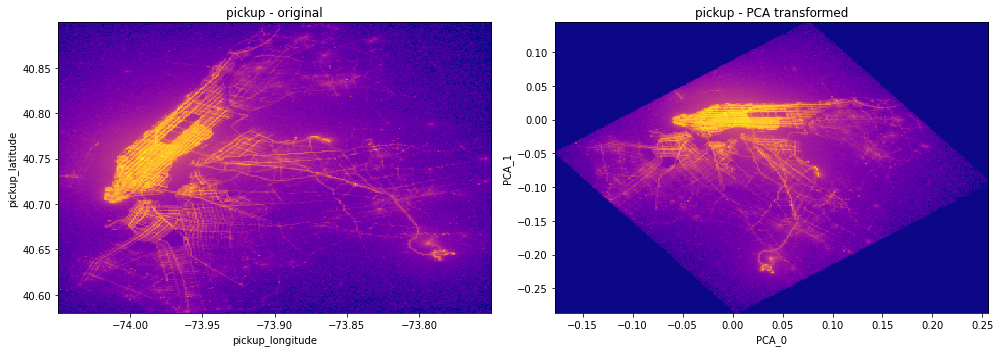

In [13]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.title('pickup - original')
df_train.plot(df_train.pickup_longitude, df_train.pickup_latitude,
           colormap='plasma', f='log1p', shape=256, colorbar=False)

plt.subplot(122)
plt.title('pickup - PCA transformed')
df_train.plot(df_train.PCA_0, df_train.PCA_1,
           colormap='plasma', f='log1p', shape=256, colorbar=False)

plt.tight_layout()
plt.show()

### Handling temporal (cyclical) features

- Assume the temporal feature is the θ coordinate of a unit circle in polar coordinates. Conver it to Cartesian (x,y) coordinates. This preserves the continuity (12 o'clock is close to 1 o'clock).

In [14]:
# Time
cycl_transform_time = vaex.ml.CycleTransformer(features=['pickup_time'], n=24)
df_train = cycl_transform_time.fit_transform(df_train)

# Day
cycl_transform_day = vaex.ml.CycleTransformer(features=['pickup_day'], n=7)
df_train = cycl_transform_day.fit_transform(df_train)

# Direction angle
cycl_transform_angle = vaex.ml.CycleTransformer(features=['direction_angle'], n=360)
df_train = cycl_transform_angle.fit_transform(df_train)

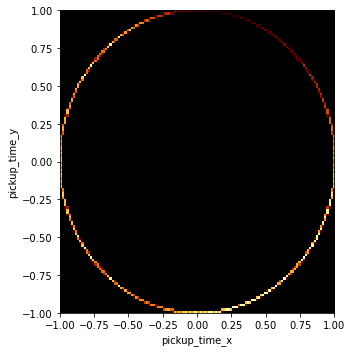

In [15]:
# Let's see how the transformed date would look like
df_train.plot(x='pickup_time_x', y='pickup_time_y',
              shape=128, limits=[-1, 1],
              figsize=(5, 5),
              colorbar=False)
plt.show()

### Scaling of numerical features

In [16]:
# Standard scaling of numerical features
standard_scaler = vaex.ml.StandardScaler(features=['arc_distance'])
df_train = standard_scaler.fit_transform(df_train)

### Preview of the features

In [17]:
# Select all the features to be used for training the model
features = df_train.get_column_names(regex='PCA*') + \
           df_train.get_column_names(regex='standard_scaled_*') + \
           df_train.get_column_names(regex='.*_x') + \
           df_train.get_column_names(regex='.*_y') + \
           ['pickup_is_weekend']

# Preview the features
df_train.head(10)[features]

#,PCA_0,PCA_1,PCA_2,PCA_3,standard_scaled_arc_distance,pickup_time_x,pickup_day_x,direction_angle_x,pickup_time_y,pickup_day_y,direction_angle_y,pickup_is_weekend
0,-0.0309657,-0.00924444,-0.0549325,-0.0194819,-0.723864,0.731354,0.62349,-0.997418,0.681998,-0.781831,-0.071816,1
1,-0.013281,-0.00813435,0.026004,-0.0100396,0.846021,0.605294,0.62349,0.770554,0.796002,-0.781831,0.637374,1
2,0.0349085,0.0188358,-0.0268513,0.00309622,0.841615,0.681998,-0.900969,-0.935657,-0.731354,0.433884,-0.35291,0
3,-0.0385416,-0.00292579,-0.0430189,0.00634483,-0.762796,-0.430511,-0.222521,0.140566,-0.902585,-0.974928,-0.990071,1
4,-0.0189817,-0.00279279,-0.0263986,-0.0105771,-0.856012,0.932008,-0.900969,-0.910151,-0.362438,-0.433884,0.414276,0
5,-0.00869784,-0.00218267,-0.00355482,-0.000696858,-0.973832,-0.691513,-0.222521,0.817867,0.722364,0.974928,0.575407,0
6,-0.0100867,0.00756843,-0.0292229,0.0002876,-0.804197,0.378649,0.62349,-0.989393,0.925541,-0.781831,-0.145266,1
7,0.00454947,-0.0101298,-0.00750884,0.00889434,0.310404,-0.386711,1,0.0883862,-0.922201,0,-0.996086,0
8,0.040219,-0.00114084,0.0300563,-0.0039338,-0.970312,0.2292,1,-0.923064,-0.973379,0,-0.384646,0
9,-0.0182094,0.0183089,0.00866001,0.00546163,0.865825,-0.0915016,1,0.452811,0.995805,0,0.891606,0


### Set the target variable

In [18]:
target = 'trip_duration_min'

### Train a machine learning model

In [19]:
from sklearn.linear_model import SGDRegressor
from vaex.ml.sklearn import IncrementalPredictor

# Define the base model
model = SGDRegressor(learning_rate='constant', eta0=0.0001)

# The Vaex incremental model wrapper
vaex_model = IncrementalPredictor(features=features,
                                  target=target,
                                  model=model,
                                  batch_size=11_000_000, 
                                  num_epochs=1, 
                                  shuffle=False, 
                                  prediction_name='predicted_duration_min')

# Fit the model
vaex_model.fit(df=df_train, progress='widget')

### Vaex makes models also behave like transformers!

In [20]:
df_train = vaex_model.transform(df_train)
# See a portion of the predictions
df_train.head(5)['trip_duration_min', 'predicted_duration_min']

#,trip_duration_min,predicted_duration_min
0,10,7.47564
1,7,11.0525
2,21.0333,15.0117
3,6.55,11.367
4,7.6,8.81215


The prediction is an expression! Opprotunities for post-processing, ensembles etc..

Values lower than 3 minutes are set to 3; values higher than 25 minutes are set to 25

In [21]:
df_train['pred_final'] = df_train.predicted_duration_min.clip(3, 25)

In [22]:
df_train.head(5)['trip_duration_min', 'predicted_duration_min', 'pred_final']

#,trip_duration_min,predicted_duration_min,pred_final
0,10,7.47564,7.47564
1,7,11.0525,11.0525
2,21.0333,15.0117,15.0117
3,6.55,11.367,11.367
4,7.6,8.81215,8.81215


## But.. what about the test set?!

### State transfer (a.k.a the `vaex` automatic pipeline)

The operations done on the data are recorded in the `state` of the DataFrame.

In [23]:
df_train.state_get()

{'virtual_columns': {'trip_duration_min': "((dropoff_datetime - pickup_datetime) / scalar_timedelta(1, 'm'))",
  'trip_speed_mph': "(trip_distance / ((dropoff_datetime - pickup_datetime) / scalar_timedelta(1, 'h')))",
  'pickup_time': '(dt_hour(pickup_datetime) + (dt_minute(pickup_datetime) / 60.0))',
  'pickup_day': 'dt_dayofweek(pickup_datetime)',
  'pickup_is_weekend': "astype((pickup_day >= 5), 'int')",
  'arc_distance': '_jit(__pickup_latitude, __pickup_longitude, __dropoff_longitude, __dropoff_latitude)',
  'direction_angle': '_jit_1(__pickup_latitude, __dropoff_longitude, __pickup_longitude, __dropoff_latitude)',
  'dropoff_latitude': 'fillna(__dropoff_latitude, value=40.76)',
  'pickup_latitude': 'fillna(__pickup_latitude, value=40.76)',
  'dropoff_longitude': 'fillna(__dropoff_longitude, value=-73.99)',
  'pickup_longitude': 'fillna(__pickup_longitude, value=-73.99)',
  'PCA_0': 'dot_product([(pickup_longitude - -73.98050062520188), (pickup_latitude - 40.75178314115146)], arg_

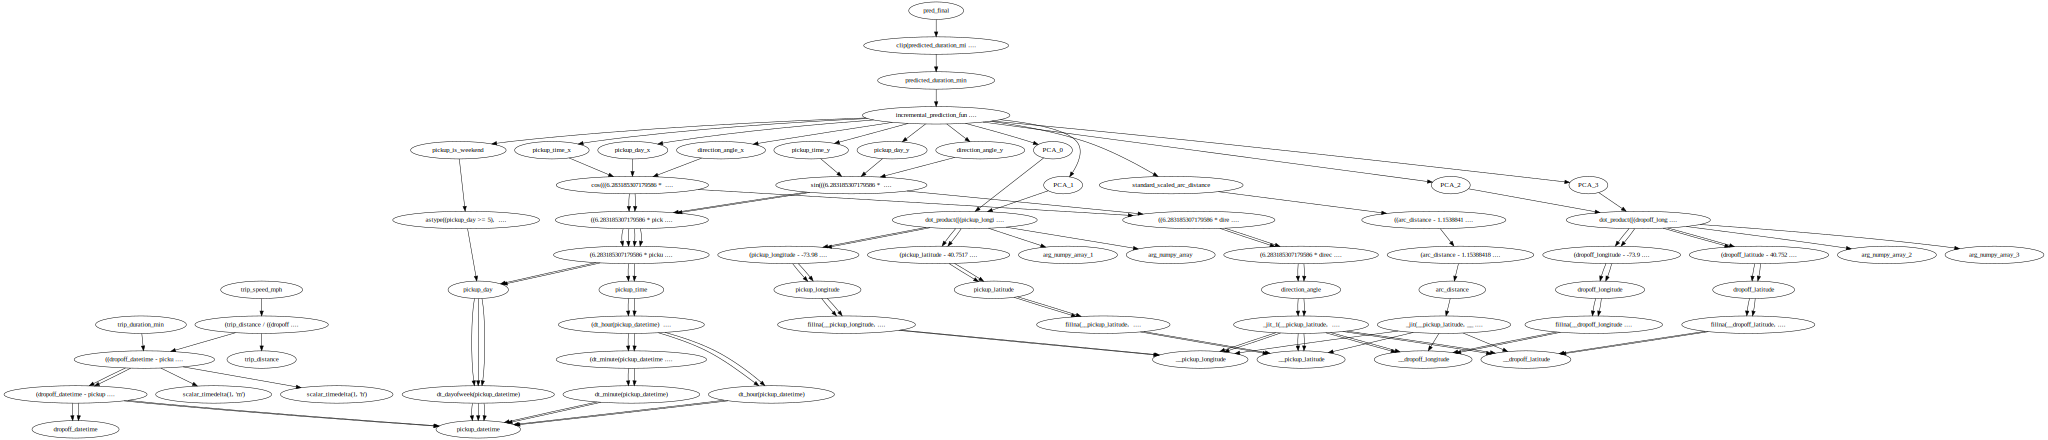

In [24]:
# The graph behind the scenes
df_train._graphviz()

### Production mode

In [25]:
# Add a variable "production" with a value set to False
df_train.add_variable('production', False)

# Add an additional filter
df_train = df_train.filter('production', mode='or')

Write the state to a cloud bucket (serializes the operations and model).

In [26]:
fs_options = {'token': '/home/jovan/.keys/vaex-282913-a6370a7624ec.json'}
df_train.state_write('gs://vaex-data/demo/taxi_ml_state.json', fs_options=fs_options)